In [1]:
import pandas as pd
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
img_path = "FootballPlayerImageClassifier/model/dataset/"
opnecv_harr_cascade = "FootballPlayerImageClassifier/model/opencv/"

In [3]:
img = cv2.imread(img_path+'lionel_messi/2_img.jpg')
img.shape

(2186, 3887, 3)

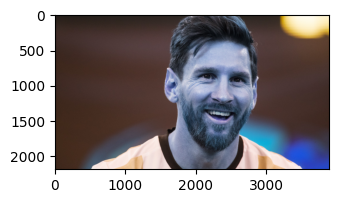

In [4]:
img_width = 6
img_height = 2

plt.figure(figsize=(img_width, img_height))
plt.imshow(img)

In [5]:
#convert image color space
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(2186, 3887)

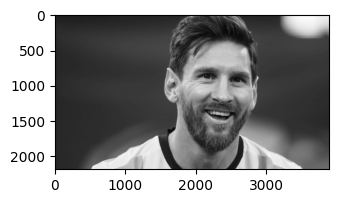

In [6]:
plt.figure(figsize=(img_width, img_height))
plt.imshow(gray, cmap='gray')

In [7]:
# Detect faces using Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(opnecv_harr_cascade+'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(opnecv_harr_cascade+'haarcascade_eye.xml')

# gray: The grayscale image on which to perform face detection
# scaleFactor: Controls image scaling at each step. Smaller values make detection more sensitive to small faces
# minNeighbors: Specifies the number of neighbors a region should have to be considered as a face
face = face_cascade.detectMultiScale(gray, 1.1, 3)
face

array([[1695,  382, 1334, 1334]])

In [8]:
(x, y, w, h) = face[0]
x, y, w, h

(1695, 382, 1334, 1334)

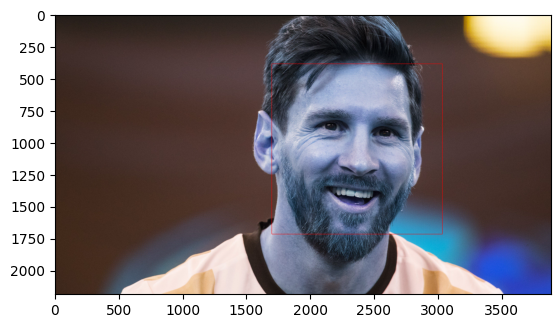

In [9]:
rectangle_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(rectangle_img)

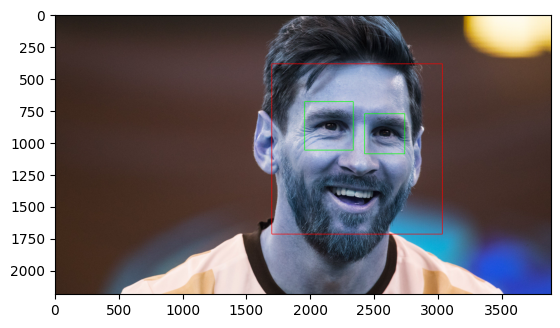

In [10]:
cv2.destroyAllWindows()
faces = face_cascade.detectMultiScale(gray, 1.1, 3)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0), 3)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0), 3)

plt.figure()
plt.imshow(img, cmap="gray")
plt.show()

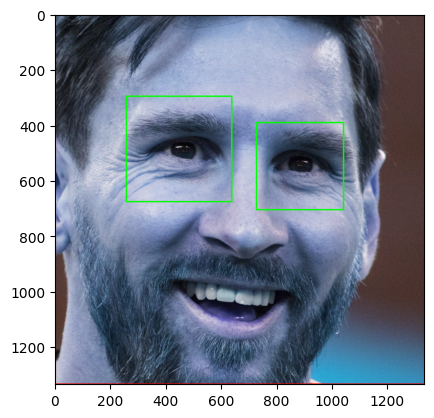

In [11]:
plt.imshow(roi_color, cmap='gray')

In [25]:
def get_cropped_images(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 3)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) > 2:
            return roi_color

In [26]:
cropped_img = get_cropped_images(img_path+'lionel_messi/1_img.jpg')

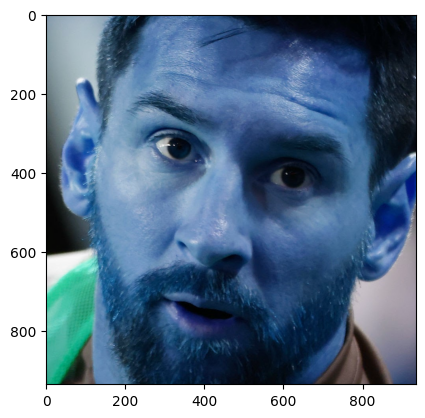

In [27]:
plt.imshow(cropped_img)